In [1]:
import time
from tqdm import tqdm
import torch
import noisereduce as nr
import librosa 
from koila import lazy
import warnings
warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))

Using cuda.


In [3]:
import pickle
with open('podcast_train_arrays.pkl', 'rb') as handle:
    podcast_train_arrays = pickle.load(handle)
with open('crowd_train_labels.pkl', 'rb') as handle:
    crowd_train_labels = pickle.load(handle)
with open('podcast_test_labels.pkl', 'rb') as handle:
    podcast_test_labels = pickle.load(handle)
with open('podcast_train_labels.pkl', 'rb') as handle:
    podcast_train_labels = pickle.load(handle)
with open('crowd_train_arrays.pkl', 'rb') as handle:
    crowd_train_arrays = pickle.load(handle)
with open('crowd_test_arrays.pkl', 'rb') as handle:
    crowd_test_arrays = pickle.load(handle)
with open('crowd_test_labels.pkl', 'rb') as handle:
    crowd_test_labels = pickle.load(handle)
with open('podcast_test_arrays.pkl', 'rb') as handle:
    podcast_test_arrays = pickle.load(handle)

In [4]:
import pandas as pd
df_train = pd.DataFrame([], columns=['array', 'emotion'])
df_train['array'] = crowd_train_arrays
df_train['emotion'] = crowd_train_labels
df_train = df_train.sample(frac=0.3, random_state=0)

podcast_df_train = pd.DataFrame([], columns=['array', 'emotion'])
podcast_df_train['array'] = podcast_train_arrays
podcast_df_train['emotion'] = podcast_train_labels

df_train = df_train.append(podcast_df_train)

In [5]:
df_train.shape

(14530, 2)

In [6]:
df_test = pd.DataFrame([], columns=['array', 'emotion'])
df_test['array'] = crowd_test_arrays
df_test['emotion'] = crowd_test_labels


podcast_df_test = pd.DataFrame([], columns=['array', 'emotion'])
podcast_df_test['array'] = podcast_test_arrays
podcast_df_test['emotion'] = podcast_test_labels

df_test = df_test.append(podcast_df_test)

In [7]:
df_test.shape

(3948, 2)

In [8]:
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [9]:
def preproc(data, sr=16000):
    data = nr.reduce_noise(data, sr=sr)
    xt, _ = librosa.effects.trim(data, top_db=33)
    return xt

In [10]:
%%time
df_train['cleaned'] = df_train['array'].apply(preproc)
df_test['cleaned'] = df_test['array'].apply(preproc)  

CPU times: total: 19min 54s
Wall time: 20min 1s


In [21]:
podcast_df_test['cleaned'] = podcast_df_test['array'].apply(preproc)  

crowd_df_test = pd.DataFrame([], columns=['array', 'emotion'])
crowd_df_test['array'] = crowd_test_arrays
crowd_df_test['emotion'] = crowd_test_labels
crowd_df_test['cleaned'] = crowd_df_test['array'].apply(preproc)  

In [11]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(df_train['cleaned']), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(df_test['cleaned']), sampling_rate=16000, padding=True, return_tensors="pt")

In [22]:
crowd_test_encodings = feature_extractor(list(crowd_df_test['cleaned']), sampling_rate=16000, padding=True, return_tensors="pt")
podcast_test_encodings = feature_extractor(list(podcast_df_test['cleaned']), sampling_rate=16000, padding=True, return_tensors="pt")

In [23]:
crowd_test_dataset = EmotionDataset(crowd_test_encodings, list(crowd_df_test['emotion']))  
podcast_test_dataset = EmotionDataset(podcast_test_encodings, list(podcast_df_test['emotion']))  

In [12]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        labels_map = {
        "angry": 0,
        "positive": 1,
        "neutral": 2,
        "sad": 3,
        #"other":4
        }
        self.labels = [labels_map[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
 

train_dataset = EmotionDataset(train_encodings, list(df_train['emotion']))
test_dataset = EmotionDataset(test_encodings, list(df_test['emotion']))  

In [13]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

model = HubertForSequenceClassification.from_pretrained("superb/hubert-base-superb-er")
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

In [14]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [15]:
from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 5

# Start training
model.train()

train_loss = list()
train_accuracies = list()
test_accuracies = list()  # create a list to store test accuracies
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        (input_ids, labels) = lazy(input_ids, labels, batch=0)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)  

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })  
        
        # record the loss for each batch
        epoch_loss.append(loss.item()) 
        
    pbar.close() 
     
    # record the and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)
    
    # run the test set through the model and calculate accuracy
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
    correct = 0
    count = 0
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            
            # make predictions
            predictions = predict(outputs)
            
            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            
    test_accuracy = correct * 1.0 / count
    test_accuracies.append(test_accuracy)
    
    print('Test accuracy: {:.3f}'.format(test_accuracy))


Epoch 1/5


100%|██████████████████████████████████████████████████| 7265/7265 [30:03<00:00,  4.03it/s, Loss=0.523, Accuracy=0.618]


Test accuracy: 0.699
Epoch 2/5


100%|██████████████████████████████████████████████████| 7265/7265 [26:51<00:00,  4.51it/s, Loss=1.308, Accuracy=0.740]


Test accuracy: 0.738
Epoch 3/5


100%|██████████████████████████████████████████████████| 7265/7265 [26:08<00:00,  4.63it/s, Loss=0.270, Accuracy=0.791]


Test accuracy: 0.753
Epoch 4/5


100%|██████████████████████████████████████████████████| 7265/7265 [24:38<00:00,  4.91it/s, Loss=0.081, Accuracy=0.831]


Test accuracy: 0.742
Epoch 5/5


100%|██████████████████████████████████████████████████| 7265/7265 [25:23<00:00,  4.77it/s, Loss=0.001, Accuracy=0.860]


Test accuracy: 0.763


In [16]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) 

model.eval()

with torch.no_grad():
       
    correct = 0
    count = 0
    c
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
                
        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)  
        accuracy = correct * 1.0 / count

        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████████████████████████████████████████████| 3948/3948 [03:12<00:00, 20.53it/s, loss=0.002, accuracy=0.790]


The final accuracy on the test dataset: 78.9767%


In [2]:
from pandas.core.frame import DataFrame
import pandas as pd
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

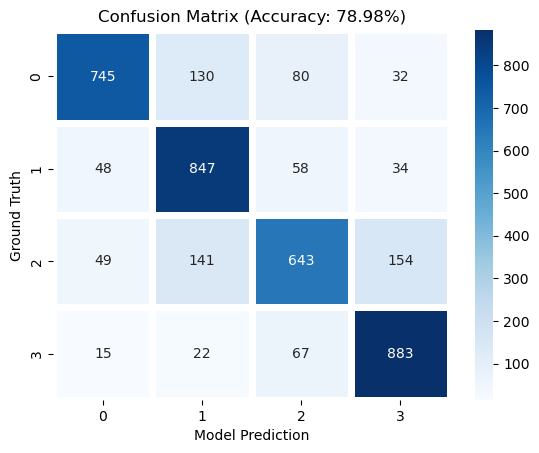

In [19]:
## import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [26]:
podcast_test_loader = DataLoader(podcast_test_dataset, batch_size=1, shuffle=False) 

model.eval()

with torch.no_grad():
       
    correct = 0
    count = 0
    podcast_record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(podcast_test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
                
        predictions = predict(outputs)
        
        correct += predictions.eq(labels).sum().item()
        count += len(labels)  
        accuracy = correct * 1.0 / count
        
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
     
        podcast_record["labels"] += labels.cpu().numpy().tolist()
        podcast_record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|████████████████████████████████████████████████████| 740/740 [00:37<00:00, 19.94it/s, loss=0.165, accuracy=0.745]


The final accuracy on the test dataset: 74.4595%


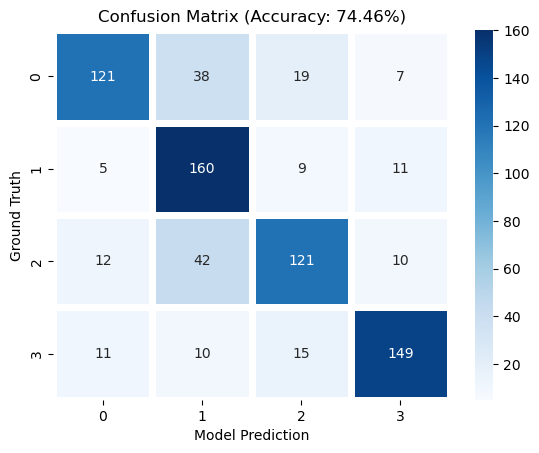

In [28]:
podcast_df_record = DataFrame(podcast_record)
podcast_df_record.columns = ["Ground Truth","Model Prediction"]

crosstab = pd.crosstab(podcast_df_record["Ground Truth"], podcast_df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy = podcast_df_record["Ground Truth"].eq(podcast _df_record["Model Prediction"]).sum() / len(podcast_df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [29]:
# Get test data by DataLoader
crowd_test_loader = DataLoader(crowd_test_dataset, batch_size=1, shuffle=False) 

# Start testing
model.eval()

with torch.no_grad():
       
    correct = 0
    count = 0
    crowd_record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(crowd_test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)  
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        crowd_record["labels"] += labels.cpu().numpy().tolist()
        crowd_record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████████████████████████████████████████████| 3208/3208 [02:39<00:00, 20.13it/s, loss=0.001, accuracy=0.800]


The final accuracy on the test dataset: 80.0499%


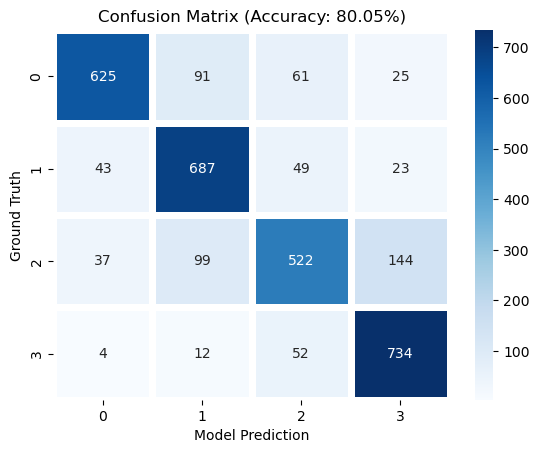

In [30]:
crowd_df_record = DataFrame(crowd_record)
crowd_df_record.columns = ["Ground Truth","Model Prediction"]

crosstab = pd.crosstab(crowd_df_record["Ground Truth"], crowd_df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy = crowd_df_record["Ground Truth"].eq(crowd_df_record["Model Prediction"]).sum() / len(crowd_df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [23]:
torch.save(model, "ser_full_789.pkl")